In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [ ]:
# read image
img = cv2.imread("/content/IMG_2678.JPG")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [ ]:
plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis("off")
plt.imsave("./original_img.png", img_rgb)
plt.close()

In [ ]:
# salt and pepper noise

def sp_noise(image,percentage):
  noise_img = image.copy()
  num_salt = int( percentage * image.size * 0.5)
  num_pepper = int( percentage * image.size * 0.5)


  for _ in range(num_salt):
    row = np.random.randint(0, image.shape[0])
    col = np.random.randint(0, image.shape[1])
    noise_img[row, col] = 255

  for _ in range(num_pepper):
    row = np.random.randint(0, image.shape[0])
    col = np.random.randint(0, image.shape[1])
    noise_img[row, col] = 0

  return noise_img


In [ ]:
noisy_img = sp_noise(img_rgb, 0.05)

(np.float64(-0.5), np.float64(3023.5), np.float64(4031.5), np.float64(-0.5))

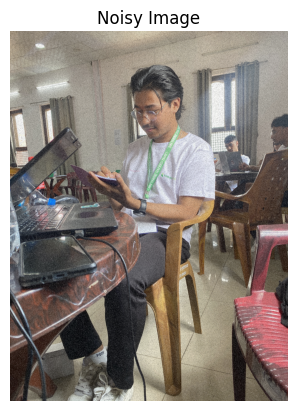

In [ ]:
plt.imshow(noisy_img)
plt.title("Noisy Image")
plt.axis("off")

In [ ]:
# Normalize to 0–1 for easier manipulation
img_rgb = img_rgb / 255.0

# Define Gaussian noise parameters
mean = 0
std = 0.5  # standard deviation (noise level)

# Generate Gaussian noise
gaussian_noise = np.random.normal(mean, std, img_rgb.shape)

# Add the noise to the image
noisy_img = img_rgb + gaussian_noise

# Clip the values to be between 0 and 1
noisy_img = np.clip(noisy_img, 0, 1)

# Convert back to 0–255
noisy_img_gaussian = (noisy_img * 255).astype(np.uint8)
img_rgb = (img_rgb * 255).astype(np.uint8)


(np.float64(-0.5), np.float64(3023.5), np.float64(4031.5), np.float64(-0.5))

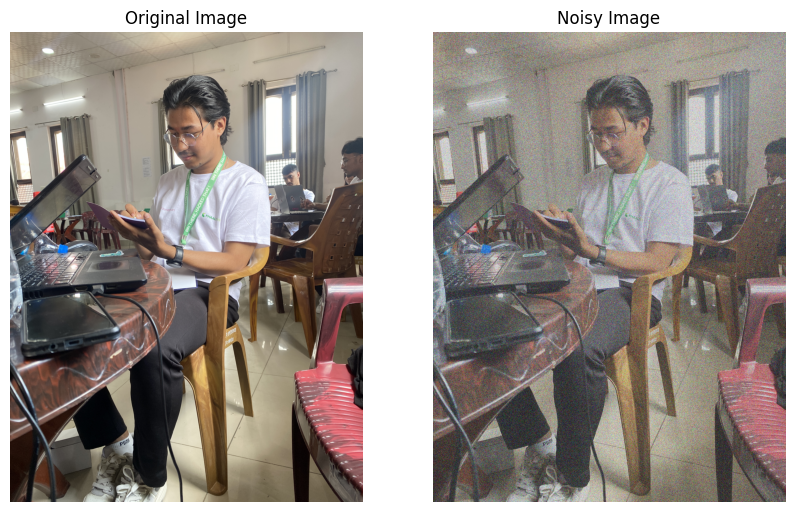

In [ ]:
# i1 = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
# i2 = cv2.cvtColor(noisy_img_gaussian, cv2.COLOR_RGB2GRAY)

i1 = img_rgb
i2 = noisy_img_gaussian
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(i1, cmap="gray")
plt.title("Original Image")

plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(i2, cmap="gray")
plt.title("Noisy Image")
plt.imsave("./gaussian.png", i2)
plt.axis("off")

In [ ]:
from skimage.filters import gaussian

In [ ]:
gauss = gaussian(i2)

(np.float64(-0.5), np.float64(3023.5), np.float64(4031.5), np.float64(-0.5))

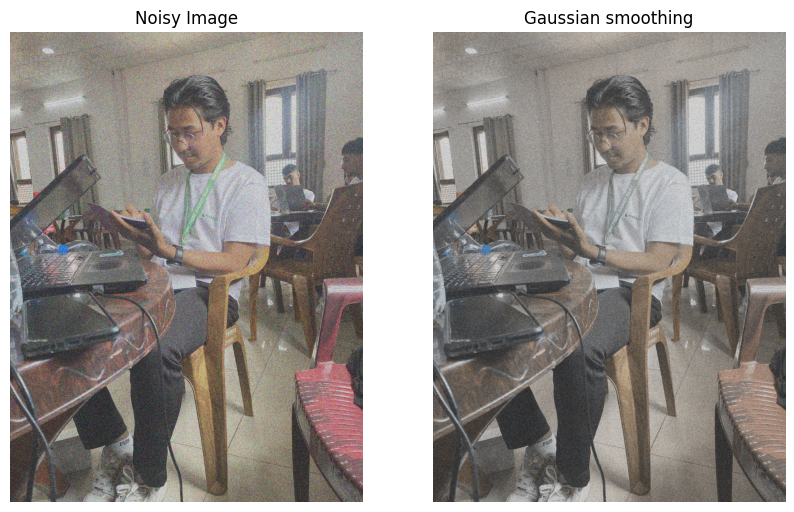

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(i2)
plt.title("Noisy Image")

plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(gauss)
plt.title("Gaussian smoothing")
plt.imsave("./gaussian_smoothing.png", gauss)
plt.axis("off")

In [ ]:
# median filter

def md_filter(image, kernal=3):
  pad = kernal // 2
  img_pad = np.pad(image, pad, mode="edge")

  filtered_img = np.zeros_like(img)

  for i in range(image.shape[0]):
    for j in range(image.shape[1]):
      window = img_pad[i:i+kernal, j:j+kernal]

      filtered_img[i,j] = np.median(window)

  return filtered_img


In [ ]:
filtered_img = md_filter(i2)

In [ ]:
filtered_img[1]

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       ...,
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]], dtype=uint8)

(np.float64(-0.5), np.float64(3023.5), np.float64(4031.5), np.float64(-0.5))

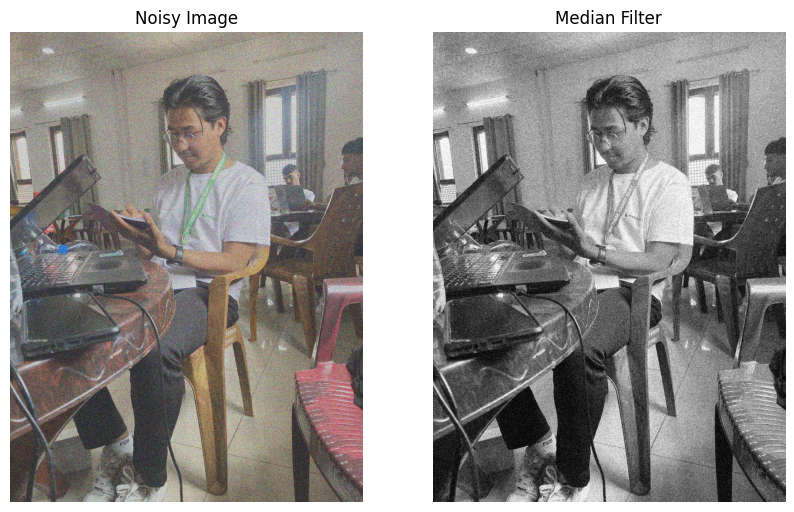

In [ ]:
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(i2, cmap="gray")
plt.title("Noisy Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(filtered_img, cmap="gray")
plt.title("Median Filter")
plt.axis("off")

In [ ]:
def md_filter_rgb(image, kernel=3):
    pad = kernel // 2
    filtered_img = np.zeros_like(image)

    # Apply median filter to each channel separately
    for c in range(3):  # 0=Red, 1=Green, 2=Blue
        channel = image[:, :, c]
        channel_padded = np.pad(channel, pad, mode="edge")
        channel_filtered = np.zeros_like(channel)

        for i in range(channel.shape[0]):
            for j in range(channel.shape[1]):
                window = channel_padded[i:i+kernel, j:j+kernel]
                channel_filtered[i, j] = np.median(window)

        filtered_img[:, :, c] = channel_filtered

    return filtered_img

In [ ]:
rgb_median_filtered = md_filter_rgb(noisy_img)

(np.float64(-0.5), np.float64(3023.5), np.float64(4031.5), np.float64(-0.5))

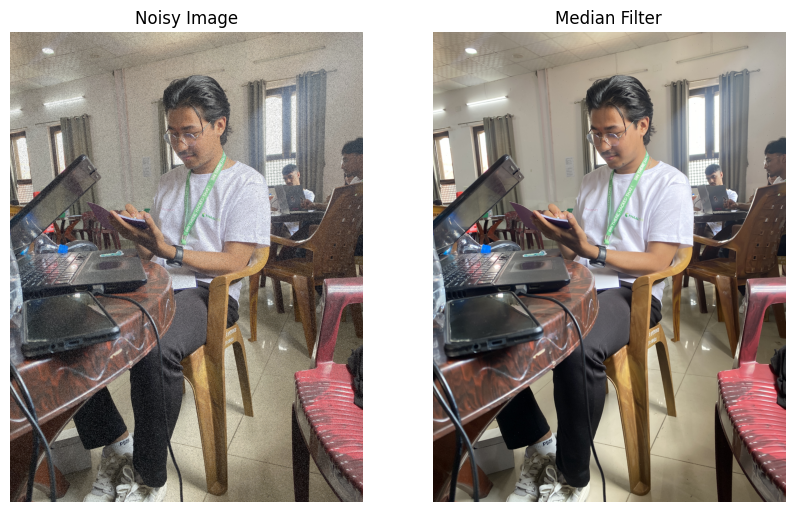

In [ ]:
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(noisy_img)
plt.title("Noisy Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(rgb_median_filtered)
plt.imsave("./median_filter.png", rgb_median_filtered)
plt.title("Median Filter")
plt.axis("off")

In [ ]:
# restoring using Adaptive noise reduction
# calculate mean absolute gradient

def MAG(image, i, j ):
  window = image[i-1:i+2, j-1:j+2].flatten()
  center = window[4]
  neighbors = np.delete(window, 4)
  return np.mean(np.abs(neighbors - center))

# adaptive filter
def adaptive_filter(image, thresold=20):
  filtered_img = image.copy()

  for c in range(3):
    channel = image[:,:,c]
    channel_pad = np.pad(channel, 1, mode = "reflect")
    channel_img = np.zeros_like(channel)

    for i in range(1, filtered_img.shape[0]+1):
      for j in range(1, filtered_img.shape[1]+1):
        mag = MAG(channel_pad, i, j )

        if mag > thresold:

          window = channel_pad[i-1:i+2, j-1: j+2].flatten()

          closest_5_idx = [4, 1, 3, 5, 7]
          others_idx = [0, 2, 6, 8]

          closest_5 = np.sort(window[closest_5_idx])
          a2 = np.median(closest_5)

          combined = np.sort(np.append(a2, window[others_idx]))
          b3 = np.median(combined)
          channel_img[i-1, j-1] = b3

        else:
          # Not noisy, keep original
          channel_img[i-1, j-1] = channel[i-1, j-1]
      filtered_img[:,:,c] = channel_img

  return filtered_img


In [ ]:
adaptive_image = adaptive_filter(noisy_img)

(np.float64(-0.5), np.float64(3023.5), np.float64(4031.5), np.float64(-0.5))

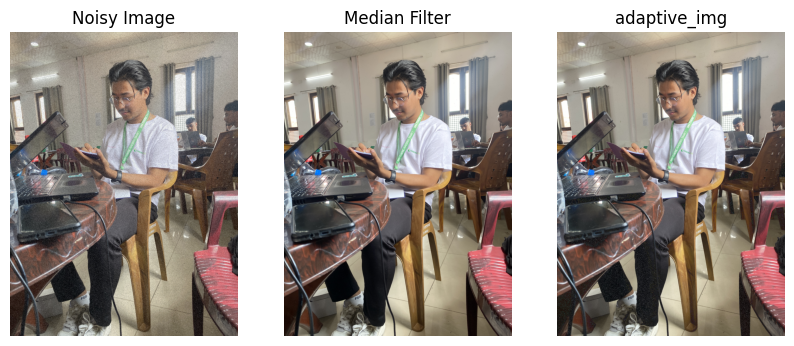

In [ ]:
plt.figure(figsize=(10,10))

plt.subplot(1,3,1)
plt.imshow(noisy_img)
plt.title("Noisy Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(rgb_median_filtered)
plt.title("Median Filter")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(adaptive_image)
plt.imsave("./median_filter.png", rgb_median_filtered)
plt.title("adaptive_img")
plt.axis("off")

In [ ]:

plt.imsave("./adaptive.png", adaptive_image)

In [ ]:
import numpy as np

def compute_std(image):
    mean = np.mean(image)
    std = np.sqrt(np.mean((image - mean) ** 2))
    return std

def conditional_enhancement(image, T=20):
    enhanced_img = image.copy()

    for c in range(3):  # Loop through each color channel
        channel = image[:, :, c]
        std = compute_std(channel)

        if std <= T:
            print(f"Skipping directional filtering for channel {c}")
            continue

        print(f"Applying directional filtering for channel {c}")
        channel_padded = np.pad(channel, 1, mode='reflect')
        enhanced_channel = np.zeros_like(channel)

        for i in range(1, channel.shape[0] + 1):
            for j in range(1, channel.shape[1] + 1):
                X = channel_padded[i - 1:i + 2, j - 1:j + 2].flatten()

                Y1 = [X[0], X[1], X[3]]  # top-left, top, left
                Y2 = [X[1], X[2], X[5]]  # top, top-right, right
                Y3 = [X[3], X[6], X[7]]  # left, bottom-left, bottom
                Y4 = [X[5], X[7], X[8]]  # right, bottom, bottom-right

                avg = (np.mean(Y1) + np.mean(Y2) + np.mean(Y3) + np.mean(Y4)) / 4

                enhanced_channel[i - 1, j - 1] = avg

        enhanced_img[:, :, c] = enhanced_channel

    return enhanced_img


In [ ]:
enhanced_i = conditional_enhancement(adaptive_image)

Applying directional filtering for channel 0
Applying directional filtering for channel 1
Applying directional filtering for channel 2


(np.float64(-0.5), np.float64(3023.5), np.float64(4031.5), np.float64(-0.5))

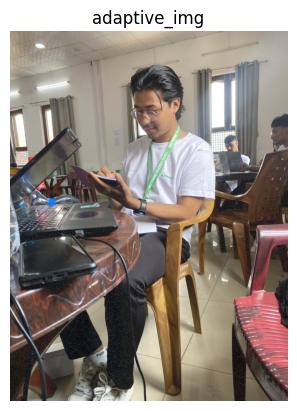

In [ ]:
plt.imshow(enhanced_i)
plt.imsave("./enhanced.png", enhanced_i)
plt.title("adaptive_img")
plt.axis("off")

In [ ]:
# convolution

def conv(img, kernal):
  img_height = img.shape[0]
  img_width  = img.shape[1]
  kernal_height = kernal.shape[0]
  kernal_width  = kernal.shape[1]

  conv_img = np.zeros_like(img, dtype=np.float64)

  pad_height = kernal_height // 2
  pad_width = kernal_width // 2

  img_pad = np.pad(img,( (pad_height, pad_height), (pad_width, pad_width)), mode="constant")

  for i in range(img_height):
    for j in range(img_width):
      window = img_pad[i:i+kernal_height, j:j+kernal_width]

      conv_img[i,j] = np.sum( window * kernal)

  return conv_img



In [ ]:
sobelX = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])

In [ ]:
edgeX = conv(gray_img, sobelX)


(4032, 3024)

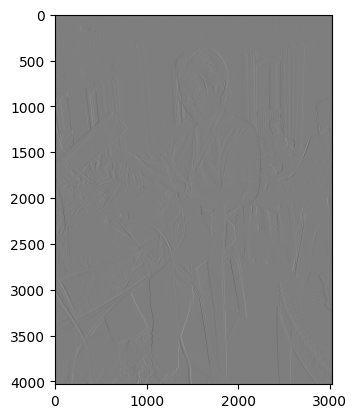

In [ ]:
plt.imshow(edgeX, cmap="gray")
plt.imsave("./Xedge.png", edgeX, cmap="gray")

In [ ]:
def convolution2d(image, kernel):

  image_height = image.shape[0]
  image_width = image.shape[1]
  kernel_height = kernel.shape[0]
  kernel_width = kernel.shape[1]
  pad_height = kernel_height // 2
  pad_width = kernel_width // 2

  output = np.zeros((image_height, image_width))              # Initialize the output image

  padded = np.pad(image,((pad_height, pad_height), (pad_width, pad_width)), mode = 'constant')   # paddded on ((up,down),(left,right))

  for i in range(image_height):
    for j in range(image_width):
      patch = padded[i: i+kernel_height, j: j+kernel_width]                                      # image patch extracted (in the next inner loop slide the patch rightwards by stride = 1) (In the outer loop, patch slides downward by 1) (combined loop gives patch size = kernel size)

      output[i,j] = np.sum(patch * kernel)                                                      # Convolution sum

  return output


In [ ]:
xsobel_output = convolution2d(gray_img, xsobel)      # edge detection in x axis


In [ ]:
xsobel = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])         # define sobel in x direction

In [ ]:
edgeX.shape

()

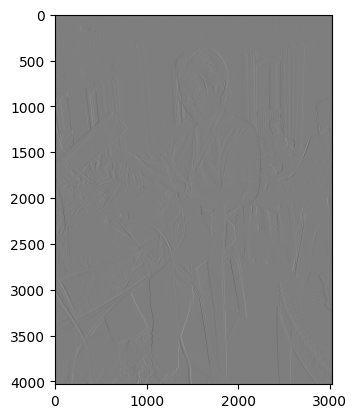

In [ ]:
plt.imshow(xsobel_output, cmap="gray")

In [ ]:
sobelY = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])

In [ ]:
edgeY = conv(gray_img, sobelY)

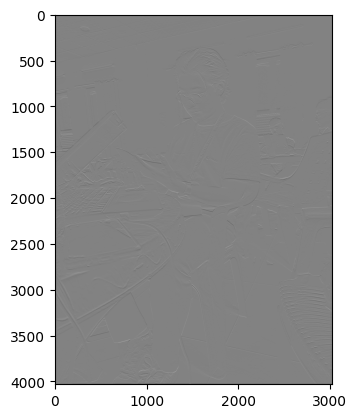

In [ ]:
plt.imshow(edgeY, cmap="gray")
plt.imsave("./Yedge.png",edgeY, cmap="gray")

In [ ]:
gray_img = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

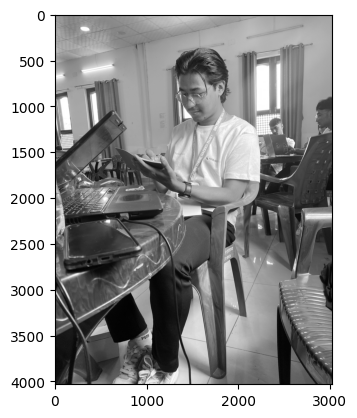

In [ ]:
plt.imshow(gray_img, cmap="gray")

In [ ]:
sobelX = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
sobelY = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])

In [ ]:

xsobel = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])

ysobel = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])

In [ ]:
total_sobel_output = np.sqrt(edgeX ** 2, edgeY ** 2)


In [ ]:
total_sobel_output = (total_sobel_output / np.max(total_sobel_output)) * 255


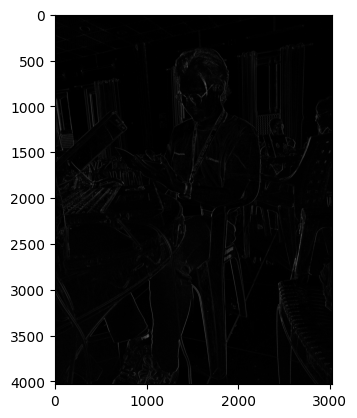

In [ ]:
total_sobel_output = total_sobel_output.astype(np.uint8)
# print(total_sobel_output)
plt.imshow(total_sobel_output, cmap="gray")
plt.imsave("./total_sobel.png", total_sobel_output, cmap="gray")

In [ ]:

from skimage.filters import laplace

edge_laplace = laplace(gray_img)

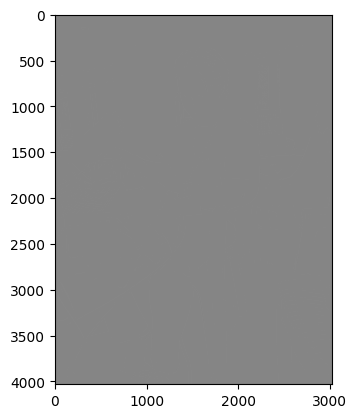

In [ ]:
plt.imshow(edge_laplace, cmap="gray")
plt.imsave("./laplace.png", edge_laplace, cmap="gray")